In [25]:
import cv2
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import os
from tqdm import tqdm

def extract_data_from_video(video_path, output_dir=None, start_index=0):
    """
    Extract lip frames and audio spectrograms from a video at 1-second intervals.
    
    Args:
        video_path: Path to the video file
        output_dir: Directory to save extracted frames and spectrograms (optional)
        start_index: Starting index for saving frames and spectrograms
    
    Returns:
        lip_frames: np.array of shape [num_seconds, 3, 64, 64]
        audio_specs: np.array of shape [num_seconds, freq_bins, time_steps]
        end_index: Last index used + 1 (for next video to continue from)
    """
    # Create directory if specified
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        os.makedirs(os.path.join(output_dir, 'frames'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'specs'), exist_ok=True)
    
    # Initialize face detector
    mtcnn = MTCNN(keep_all=False, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    num_seconds = int(duration)
    
    # Extract audio
    y, sr = librosa.load(video_path, sr=16000)
    
    lip_frames = []
    audio_specs = []
    
    current_index = start_index
    print(f"Processing {os.path.basename(video_path)} - {num_seconds} seconds - starting from index {start_index}")
    
    for tenth_sec in tqdm(range(int(num_seconds * 10))):  # Multiply by 10 for 0.1s intervals
        sec = tenth_sec / 10.0  # Convert to actual time in seconds
        frame_idx = int(sec * fps)  # Get exact frame for this time point
        
        # Set video position to middle frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Could not read frame at second {sec}")
            continue
        
        # Convert to RGB (MTCNN expects RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect face
        boxes, _ = mtcnn.detect(frame_rgb)
        
        if boxes is None or len(boxes) == 0:
            print(f"No face detected at second {sec}")
            continue
        
        # Get face box
        box = boxes[0].astype(int)
        x1, y1, x2, y2 = box
        
        # Get bottom half of face for lip region (approximate)
        face_height = y2 - y1
        lip_y1 = y1 + int(face_height * 0.65)
        lip_y2 = y2
        
        # Add margin to width for better lip capture
        face_width = x2 - x1
        margin = face_width * 0.1
        lip_x1 = max(0, int(x1 - margin))
        lip_x2 = min(frame.shape[1], int(x2 + margin))
        
        # Crop lip region
        lip_crop = frame_rgb[lip_y1:lip_y2, lip_x1:lip_x2]
        
        # Resize to 64x64
        try:
            lip_crop = cv2.resize(lip_crop, (64, 64))
        except:
            print(f"Error resizing lip crop at second {sec}")
            continue
        
        # Convert to torch format [C, H, W]
        lip_crop = lip_crop.transpose(2, 0, 1) / 255.0
        
        # Get 1-second audio segment
        start_sample = int(sec * sr)
        end_sample = int((sec + 0.1) * sr)
        
        # Fix in extract_data_from_video function
        if end_sample > len(y):
            # Handle last segment that might be shorter
            audio_segment = y[start_sample:]
            if len(audio_segment) < sr/20:  # Skip if too short (less than 0.05s)
                continue
            # Pad if needed - fix to use sr/10 for 0.1s segments
            audio_segment = np.pad(audio_segment, (0, int(sr/10) - len(audio_segment)), 'constant')
        else:
            audio_segment = y[start_sample:end_sample]
        
        # Create mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio_segment, 
            sr=sr, 
            n_fft=512, 
            hop_length=256, 
            n_mels=128
        )
        
        # Convert to log scale
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize to [0, 1]
        log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
        
        # Save if output directory is specified
        if output_dir:
            # Save lip frame using the global index
            plt.imsave(
                os.path.join(output_dir, 'frames', f'lip_{current_index}.jpg'), 
                lip_crop.transpose(1, 2, 0)
            )
            
            # Save spectrogram using the global index
            plt.figure(figsize=(4, 4))
            plt.imshow(log_mel_spec, aspect='auto', origin='lower')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'specs', f'spec_{current_index}.jpg'))
            plt.close()
        
        # Add to collections
        lip_frames.append(lip_crop)
        audio_specs.append(log_mel_spec)
        
        # Increment the global index
        current_index += 1
    
    cap.release()
    
    # Convert to numpy arrays
    lip_frames = np.array(lip_frames, dtype=np.float32)
    audio_specs = np.array(audio_specs, dtype=np.float32)
    
    num_extracted = len(lip_frames)
    print(f"Extracted {num_extracted} pairs of frames and spectrograms")
    if num_extracted > 0:
        print(f"Lip frames shape: {lip_frames.shape}")
        print(f"Audio spectrograms shape: {audio_specs.shape}")
    
    return lip_frames, audio_specs, current_index

def process_videos_from_directory(videos_directory, output_dir):
    """
    Process all videos in a directory, maintaining continuous frame numbering.
    
    Args:
        videos_directory: Path to directory containing video files
        output_dir: Directory to save the extracted frames and spectrograms
    
    Returns:
        all_lip_frames: List of lip frames arrays from all videos
        all_audio_specs: List of audio spectrograms from all videos
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'frames'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'specs'), exist_ok=True)
    
    # Check if directory exists
    if not os.path.isdir(videos_directory):
        raise ValueError(f"Directory does not exist: {videos_directory}")
    
    # Define video file extensions to look for
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm']
    
    # Get all video files in the directory
    video_paths = []
    for file in os.listdir(videos_directory):
        file_path = os.path.join(videos_directory, file)
        if os.path.isfile(file_path) and any(file.lower().endswith(ext) for ext in video_extensions):
            video_paths.append(file_path)
    
    print(f"Found {len(video_paths)} video files in {videos_directory}")
    
    # Initialize
    all_lip_frames = []
    all_audio_specs = []
    current_index = 0
    
    # Process each video
    for video_idx, video_path in enumerate(video_paths):
        print(f"\nProcessing video {video_idx+1}/{len(video_paths)}: {os.path.basename(video_path)}")
        
        try:
            # Extract data from this video, continuing from the current index
            lip_frames, audio_specs, next_index = extract_data_from_video(
                video_path, 
                output_dir=output_dir, 
                start_index=current_index
            )
            
            # Update the current index for the next video
            current_index = next_index
            
            # Add to collections if frames were extracted
            if len(lip_frames) > 0:
                all_lip_frames.append(lip_frames)
                all_audio_specs.append(audio_specs)
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            continue
    
    print(f"\nFinished processing all videos. Total frames extracted: {current_index}")
    
    # If we have data, combine it
    if all_lip_frames and all_audio_specs:
        combined_lip_frames = np.concatenate(all_lip_frames, axis=0)
        combined_audio_specs = np.concatenate(all_audio_specs, axis=0)
        
        print(f"Combined data shapes:")
        print(f"Lip frames: {combined_lip_frames.shape}")
        print(f"Audio spectrograms: {combined_audio_specs.shape}")
        
        # Save metadata
        with open(os.path.join(output_dir, 'metadata.txt'), 'w') as f:
            f.write(f"Total videos processed: {len(video_paths)}\n")
            f.write(f"Total frames extracted: {current_index}\n")
            f.write(f"Combined lip frames shape: {combined_lip_frames.shape}\n")
            f.write(f"Combined audio spectrograms shape: {combined_audio_specs.shape}\n")
            f.write("\nSource videos:\n")
            for idx, path in enumerate(video_paths):
                f.write(f"{idx+1}. {path}\n")
        
        return combined_lip_frames, combined_audio_specs
    else:
        print("No valid data was extracted from any video.")
        return None, None

def prepare_model_input(lip_frames, audio_specs):
    """
    Convert numpy arrays to torch tensors in the format expected by the model.
    
    Returns:
        lip_frames_tensor: torch.Tensor of shape [1, seq_len, 3, 64, 64]
        audio_specs_tensor: torch.Tensor of shape [1, seq_len, freq_bins, time_steps]
    """
    # Convert to torch tensors
    lip_frames_tensor = torch.from_numpy(lip_frames)
    
    # Reshape audio specs to [seq_len, 1, freq_bins, time_steps] then to [seq_len, freq_bins, time_steps]
    audio_specs_tensor = torch.from_numpy(audio_specs)
    
    # Add batch dimension
    lip_frames_tensor = lip_frames_tensor.unsqueeze(0)  # [1, seq_len, 3, 64, 64]
    audio_specs_tensor = audio_specs_tensor.unsqueeze(0)  # [1, seq_len, freq_bins, time_steps]
    
    return lip_frames_tensor, audio_specs_tensor

videos_dir = "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/lipsync/videos"
output_dir = "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/lipsync/extracted_data"
#lip_frames, audio_specs = process_videos_from_directory(videos_dir, output_dir)
#if lip_frames is not None and audio_specs is not None:
#    lip_frames_tensor, audio_specs_tensor = prepare_model_input(lip_frames, audio_specs)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SelfAttention(nn.Module):
    def __init__(self, embedding_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.scale = embedding_dim ** 0.5
    
    def forward(self, x):
        # x shape: (batch, seq_len, embedding_dim)
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        attention = F.softmax(scores, dim=-1)
        
        # Apply attention
        return torch.matmul(attention, v)

class CrossModalAttention(nn.Module):
    def __init__(self, visual_dim, audio_dim):
        super(CrossModalAttention, self).__init__()
        self.visual_projection = nn.Linear(visual_dim, visual_dim)
        self.audio_projection = nn.Linear(audio_dim, visual_dim)
        self.scale = visual_dim ** 0.5
    
    def forward(self, visual_feats, audio_feats):
        # Project features to common space
        visual_proj = self.visual_projection(visual_feats)
        audio_proj = self.audio_projection(audio_feats)
        
        # Compute cross-modal attention
        scores = torch.matmul(visual_proj, audio_proj.transpose(-2, -1)) / self.scale
        attention = F.softmax(scores, dim=-1)
        
        # Apply attention in both directions
        visual_attended = torch.matmul(attention, audio_feats)
        audio_attended = torch.matmul(attention.transpose(-2, -1), visual_feats)
        
        return visual_attended, audio_attended

class VisualFeatureStream(nn.Module):
    def __init__(self, output_dim=256):
        super(VisualFeatureStream, self).__init__()
        # Use a pretrained face model and adapt for lip features
        base_model = models.resnet18(pretrained=True)
        self.base_layers = nn.Sequential(*list(base_model.children())[:-2])
        
        # Lip-specific feature extraction
        self.lip_feature_extraction = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Temporal modeling
        self.temporal_conv = TemporalConvBlock(256, output_dim)
        
        # Self-attention
        self.self_attention = SelfAttention(output_dim)
    
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape
        
        # Reshape for CNN processing
        x = x.view(batch_size * seq_len, c, h, w)
        
        # Process through base network
        x = self.base_layers(x)
        
        # Extract lip-specific features
        x = self.lip_feature_extraction(x).squeeze(-1).squeeze(-1)
        
        # Reshape back to sequence
        x = x.view(batch_size, seq_len, -1)
        
        # Prepare for temporal conv (B, C, T)
        x_t = x.transpose(1, 2)
        x_t = self.temporal_conv(x_t)
        
        # Back to (B, T, C) for attention
        x = x_t.transpose(1, 2)
        
        # Self-attention
        x = self.self_attention(x)
        
        return x

class AudioFeatureStream(nn.Module):
    def __init__(self, output_dim=256):
        super(AudioFeatureStream, self).__init__()
        # Audio feature extraction (similar to VGGish or PANNs)
        self.audio_feature_extraction = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Temporal modeling
        self.temporal_conv = TemporalConvBlock(256, output_dim)
        
        # Self-attention
        self.self_attention = SelfAttention(output_dim)
    
    def forward(self, x):
        # x shape: (batch, seq_len, freq_bins, time_steps)
        batch_size, seq_len, freq_bins, time_steps = x.shape
        
        # Reshape for CNN processing
        x = x.view(batch_size * seq_len, 1, freq_bins, time_steps)
        
        # Process spectrogram features
        x = self.audio_feature_extraction(x).squeeze(-1).squeeze(-1)
        
        # Reshape back to sequence
        x = x.view(batch_size, seq_len, -1)
        
        # Prepare for temporal conv (B, C, T)
        x_t = x.transpose(1, 2)
        x_t = self.temporal_conv(x_t)
        
        # Back to (B, T, C) for attention
        x = x_t.transpose(1, 2)
        
        # Self-attention
        x = self.self_attention(x)
        
        return x

class LipSyncVerificationModel(nn.Module):
    def __init__(self, feature_dim=256, lstm_hidden_dim=128):
        super(LipSyncVerificationModel, self).__init__()
        
        # Feature streams
        self.visual_stream = VisualFeatureStream(feature_dim)
        self.audio_stream = AudioFeatureStream(feature_dim)
        
        # Cross-modal attention
        self.cross_attention = CrossModalAttention(feature_dim, feature_dim)
        
        # Feature fusion
        self.fusion_layer = nn.Linear(feature_dim * 4, feature_dim * 2)
        
        # Temporal modeling with Bi-LSTM
        self.bilstm = nn.LSTM(
            input_size=feature_dim * 2,
            hidden_size=lstm_hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Final classification layers
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, lstm_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_dim // 2, 1)
        )
        
    def forward(self, lip_frames, audio_spectrograms):
        """
        Args:
            lip_frames: Tensor of shape [batch_size, seq_len, 3, 64, 64]
            audio_spectrograms: Tensor of shape [batch_size, seq_len, freq_bins, time_steps]
        """
        # Process through feature streams
        visual_features = self.visual_stream(lip_frames)
        audio_features = self.audio_stream(audio_spectrograms)
        
        # Cross-modal attention
        visual_attended, audio_attended = self.cross_attention(visual_features, audio_features)
        
        # Feature fusion
        fused_features = torch.cat([
            visual_features, 
            visual_attended, 
            audio_features, 
            audio_attended
        ], dim=-1)
        
        fused_features = self.fusion_layer(fused_features)
        
        # Temporal modeling
        lstm_out, _ = self.bilstm(fused_features)
        
        # Take features from last timestep
        final_feature = lstm_out[:, -1, :]
        
        # Classification
        logits = self.fc_layers(final_feature)
        
        return torch.sigmoid(logits)

C:\Users\alapa\AppData\Local\Temp\ipykernel_24812\283098711.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_path, sr=16000)


Processing WhatsApp Video 2025-04-21 at 22.54.57_d02347e4.mp4 - 18 seconds - starting from index 0


 59%|█████▉    | 106/180 [00:13<00:07, 10.27it/s]

No face detected at second 10.4
No face detected at second 10.5
No face detected at second 10.6


 61%|██████    | 110/180 [00:13<00:06, 10.90it/s]

No face detected at second 10.7
No face detected at second 10.8
No face detected at second 10.9


 62%|██████▏   | 112/180 [00:13<00:06, 11.08it/s]

No face detected at second 11.0
No face detected at second 11.1
No face detected at second 11.2


 64%|██████▍   | 116/180 [00:14<00:05, 11.02it/s]

No face detected at second 11.3
No face detected at second 11.4
No face detected at second 11.5


100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Extracted 168 pairs of frames and spectrograms
Lip frames shape: (168, 3, 64, 64)
Audio spectrograms shape: (168, 128, 7)
Training samples: 8
Validation samples: 2
Epoch 1/100:
  Train Loss: 0.7277
  Val Loss: 0.7371
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 2/100:
  Train Loss: 0.7282
  Val Loss: 0.7354
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 3/100:
  Train Loss: 0.7110
  Val Loss: 0.7334
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 4/100:
  Train Loss: 0.7094
  Val Loss: 0.7311
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 5/100:
  Train Loss: 0.7039
  Val Loss: 0.7279
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 6/100:
  Train Loss: 0.6916
  Val Loss: 0.7244
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 7/100:
  Train Loss: 0.6921
  Val Loss: 0.7205
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 8/100:
  Train Loss: 0.6841
  Val Loss: 0.7166
  Val Accuracy: 0.0000
  Val AUC: 0.0000
Epoch 9/100:
  Train Loss: 0.6580
  Val Loss: 0.7124
  Val Accuracy: 0.0000
  Val AU

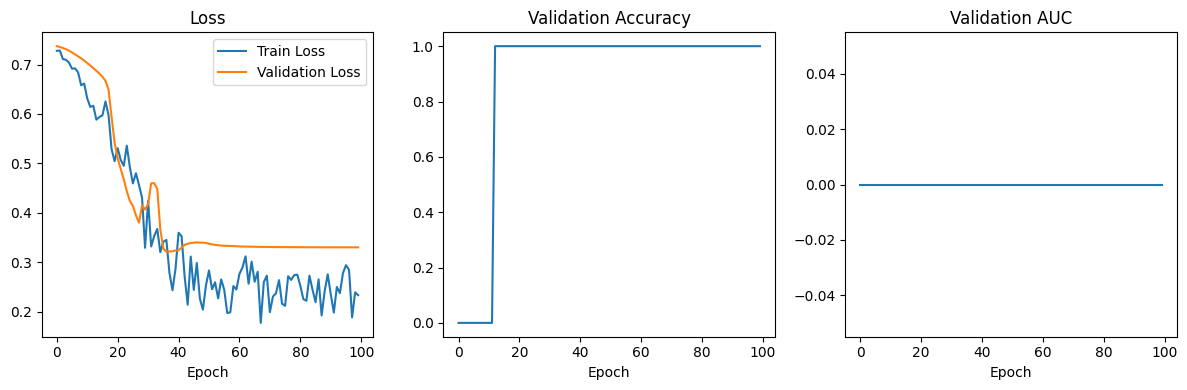

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

class LipSyncDataset(Dataset):
    def __init__(self, lip_frames_list, audio_specs_list, labels):
        """
        Dataset for training lip sync verification.
        
        Args:
            lip_frames_list: List of lip frames arrays, each of shape [seq_len, 3, 64, 64]
            audio_specs_list: List of audio spectrograms, each of shape [seq_len, freq_bins, time_steps]
            labels: Binary labels (1 for synced, 0 for not synced)
        """
        self.lip_frames_list = lip_frames_list
        self.audio_specs_list = audio_specs_list
        self.labels = labels
        
    def __len__(self):
        return len(self.lip_frames_list)
    
    def __getitem__(self, idx):
        return {
            'lip_frames': torch.from_numpy(self.lip_frames_list[idx]),
            'audio_specs': torch.from_numpy(self.audio_specs_list[idx]),
            'labels': torch.tensor([self.labels[idx]], dtype=torch.float32)
        }

def create_synced_and_unsynced_pairs(lip_frames, audio_specs, num_unsynced_pairs=1):
    """
    Create synced and unsynced pairs from a single video.
    For unsynced pairs, we shuffle the audio segments relative to the lip frames.
    """
    # Original synced pair
    synced_pairs = [(lip_frames, audio_specs)]
    labels = [1]  # 1 for synced
    
    # Create unsynced pairs by shuffling audio
    for _ in range(num_unsynced_pairs):
        # Create a random temporal shift for audio (circular shift)
        shift_amount = np.random.randint(1, len(audio_specs))
        shifted_audio = np.roll(audio_specs, shift_amount, axis=0)
        
        synced_pairs.append((lip_frames, shifted_audio))
        labels.append(0)  # 0 for not synced
    
    return synced_pairs, labels

def train_model(model, lip_frames, audio_specs, batch_size=4, epochs=100, lr=0.0001, val_split=0.2):
    """
    Train the lip sync verification model.
    
    Args:
        model: The LipSyncVerificationModel
        lip_frames: Lip frames of shape [seq_len, 3, 64, 64]
        audio_specs: Audio spectrograms of shape [seq_len, freq_bins, time_steps]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create synced and unsynced pairs - INCREASE THIS NUMBER FOR MORE TRAINING SAMPLES
    pairs, labels = create_synced_and_unsynced_pairs(lip_frames, audio_specs, num_unsynced_pairs=9)
    
    # Extract lip frames and audio specs from pairs
    lip_frames_list = [pair[0] for pair in pairs]
    audio_specs_list = [pair[1] for pair in pairs]
    
    # Split data into training and validation
    num_samples = len(lip_frames_list)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    # Ensure at least 1 sample for validation
    val_size = max(1, int(val_split * num_samples))
    # Ensure at least 1 sample for training
    val_size = min(val_size, num_samples - 1)
    
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]
    
    # Create training and validation datasets
    train_dataset = LipSyncDataset(
        [lip_frames_list[i] for i in train_indices],
        [audio_specs_list[i] for i in train_indices],
        [labels[i] for i in train_indices]
    )
    
    val_dataset = LipSyncDataset(
        [lip_frames_list[i] for i in val_indices],
        [audio_specs_list[i] for i in val_indices],
        [labels[i] for i in val_indices]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_auc': []
    }
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            lip_frames_batch = batch['lip_frames'].to(device)
            audio_specs_batch = batch['audio_specs'].to(device)
            labels_batch = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(lip_frames_batch, audio_specs_batch)
            
            # Calculate loss
            loss = criterion(outputs, labels_batch)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_outputs = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                lip_frames_batch = batch['lip_frames'].to(device)
                audio_specs_batch = batch['audio_specs'].to(device)
                labels_batch = batch['labels'].to(device)
                
                outputs = model(lip_frames_batch, audio_specs_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()
                
                # Collect outputs and labels for AUC calculation
                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels_batch.cpu().numpy())
        
        val_outputs = np.array(val_outputs)
        val_labels = np.array(val_labels)
        
        # Calculate validation metrics
        val_accuracy = ((val_outputs > 0.5) == val_labels).mean()
        
        # Calculate AUC if possible
        if len(np.unique(val_labels)) > 1:
            fpr, tpr, _ = roc_curve(val_labels, val_outputs)
            val_auc = auc(fpr, tpr)
        else:
            val_auc = 0
        
        # Update history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_accuracy)
        history['val_auc'].append(val_auc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss / len(train_loader):.4f}')
        print(f'  Val Loss: {val_loss / len(val_loader):.4f}')
        print(f'  Val Accuracy: {val_accuracy:.4f}')
        print(f'  Val AUC: {val_auc:.4f}')
        
        # Update learning rate
        scheduler.step(val_loss / len(val_loader))
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_auc'])
    plt.title('Validation AUC')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    return model, history


model = LipSyncVerificationModel()
lip_frames, audio_specs,_ = extract_data_from_video("C:/Users/alapa/Downloads/Authentica---DeepFake-detection/testcases/WhatsApp Video 2025-04-21 at 22.54.57_d02347e4.mp4")
trained_model, history = train_model(model, lip_frames, audio_specs)

In [28]:
torch.save(model.state_dict(), "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/lipsync/model_weights.pth")

C:\Users\alapa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\alapa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\alapa\AppData\Local\Temp\ipykernel_24812\283098711.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_path, sr=16000)
C:\Users

Extracting data from C:/Users/alapa/Downloads/Authentica---DeepFake-detection/flask_app/video/ca.mp4...
Processing ca.mp4 - 1 seconds - starting from index 0


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\alapa\AppData\Local\Temp\ipykernel_24812\283098711.py:129: RuntimeWarning: invalid value encountered in divide
  log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Extracted 10 pairs of frames and spectrograms
Lip frames shape: (10, 3, 64, 64)
Audio spectrograms shape: (10, 128, 7)
Video too short (1.0 seconds). Minimum required: 10.0 seconds.


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


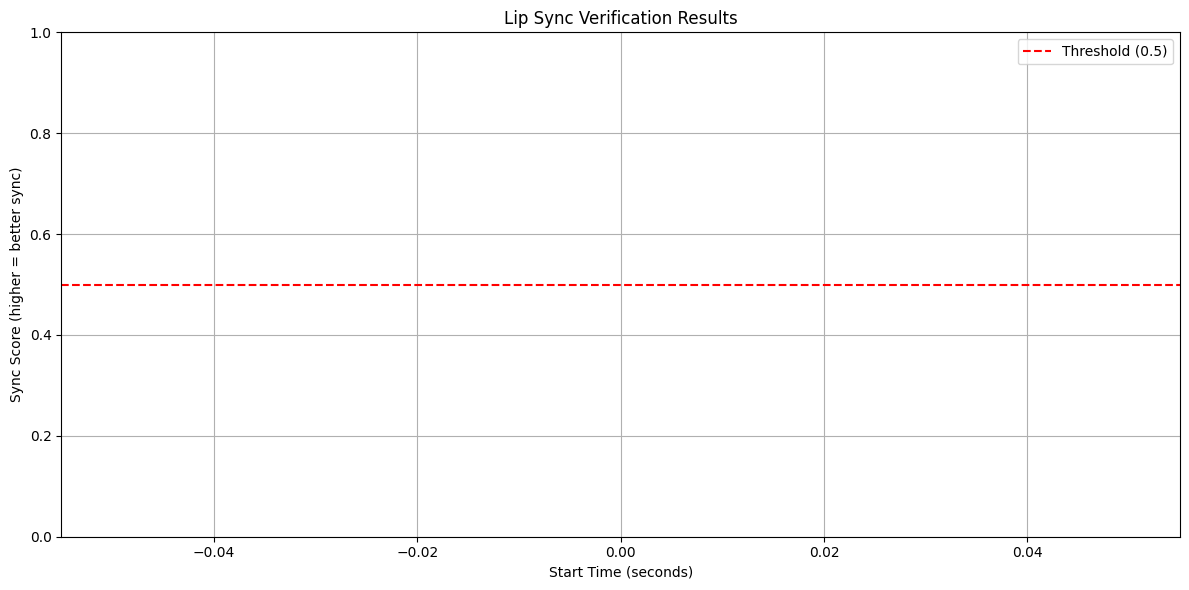


Overall lip sync quality: nan

No significant lip sync issues detected.
Extracting data from C:/Users/alapa/Downloads/Authentica---DeepFake-detection/testcases/rahulgandhi-deepfake-video.mp4...
Processing rahulgandhi-deepfake-video.mp4 - 18 seconds - starting from index 0


  0%|          | 0/180 [00:00<?, ?it/s]

No face detected at second 0.0
No face detected at second 0.1


  2%|▏         | 4/180 [00:00<00:04, 36.66it/s]

No face detected at second 0.2
No face detected at second 0.3
No face detected at second 0.4
No face detected at second 0.5
No face detected at second 0.6


  4%|▍         | 8/180 [00:00<00:04, 35.56it/s]

No face detected at second 0.7


 46%|████▌     | 83/180 [00:05<00:05, 19.35it/s]

No face detected at second 7.8
No face detected at second 7.9
No face detected at second 8.0
No face detected at second 8.1
No face detected at second 8.2
No face detected at second 8.3
No face detected at second 8.4
No face detected at second 8.5


 50%|█████     | 90/180 [00:06<00:03, 23.03it/s]

No face detected at second 8.6


100%|██████████| 180/180 [00:10<00:00, 17.87it/s]


Extracted 163 pairs of frames and spectrograms
Lip frames shape: (163, 3, 64, 64)
Audio spectrograms shape: (163, 128, 7)


100%|██████████| 2/2 [00:00<00:00, 15.03it/s]


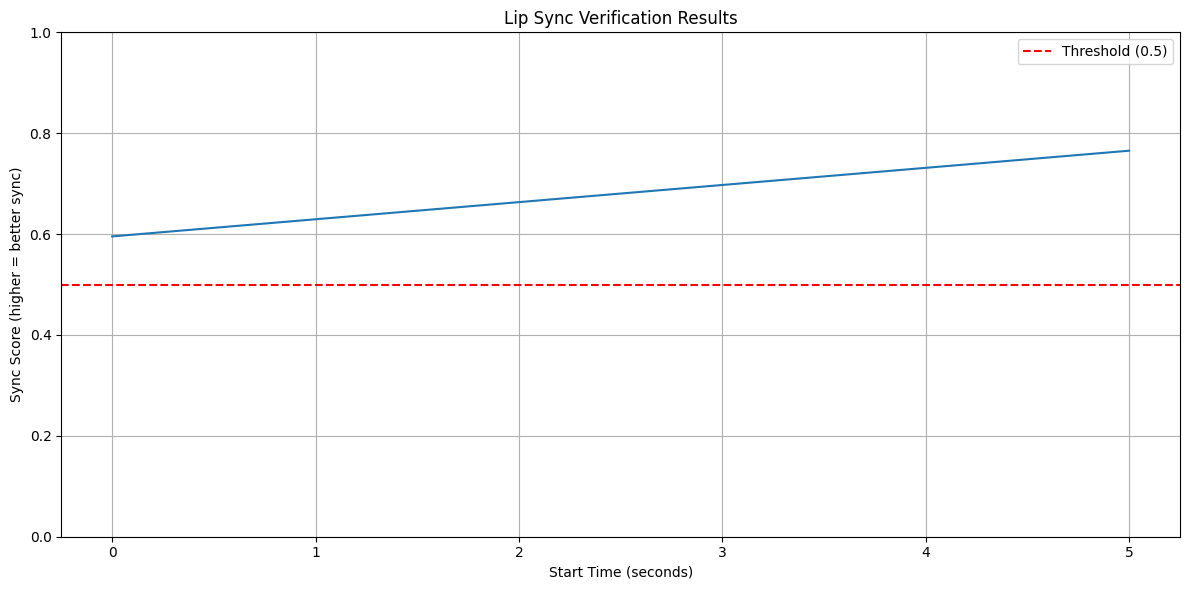


Overall lip sync quality: 0.6804

No significant lip sync issues detected.
Extracting data from C:/Users/alapa/Downloads/Authentica---DeepFake-detection/testcases/WhatsApp Video 2025-04-21 at 22.55.05_f46acb07.mp4...
Processing WhatsApp Video 2025-04-21 at 22.55.05_f46acb07.mp4 - 12 seconds - starting from index 0


100%|██████████| 120/120 [00:27<00:00,  4.38it/s]


Extracted 120 pairs of frames and spectrograms
Lip frames shape: (120, 3, 64, 64)
Audio spectrograms shape: (120, 128, 7)


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


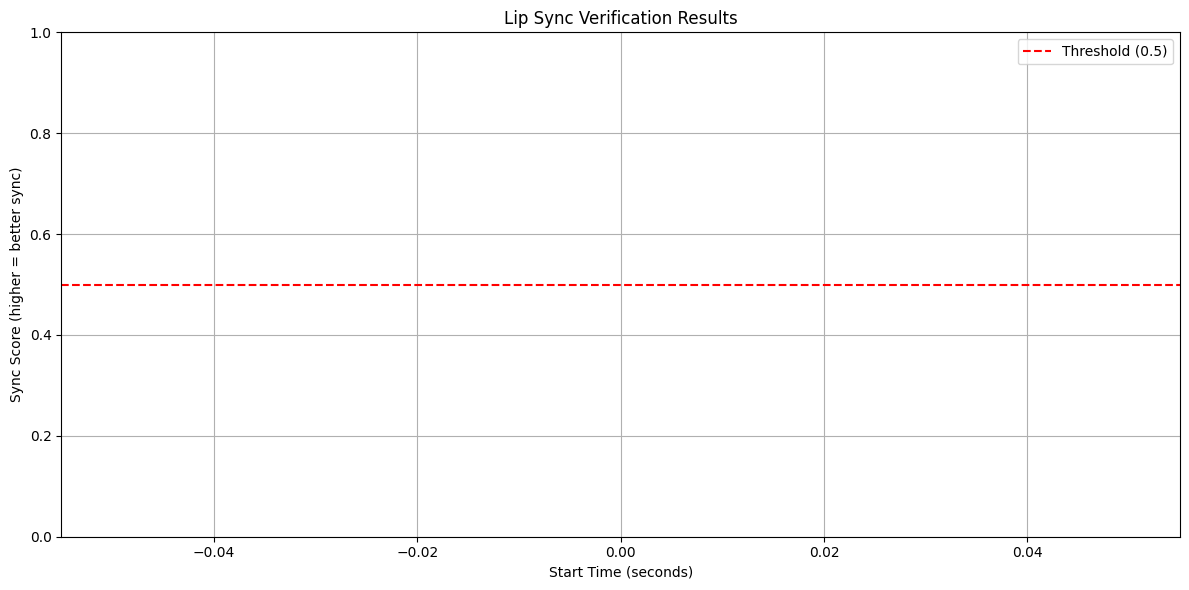


Overall lip sync quality: 0.7537

No significant lip sync issues detected.


In [36]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa

def run_inference(model, video_path, window_size=100, step_size=50, threshold=0.5):
    """
    Run inference on a video to detect lip sync issues.
    
    Args:
        model: Trained LipSyncVerificationModel
        video_path: Path to the video file
        window_size: Number of 0.1-second intervals to analyze at once (default 100 = 10 seconds)
        step_size: Number of 0.1-second intervals to move the window (default 50 = 5 seconds)
        threshold: Threshold for considering the audio and video synced
        
    Returns:
        results: Dictionary with timestamps and sync scores
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Extract all frames and audio
    print(f"Extracting data from {video_path}...")
    # In run_inference function
    lip_frames, audio_specs, _ = extract_data_from_video(video_path, start_index=0)
    
    # Get total duration in 0.1 second intervals
    total_intervals = len(lip_frames)
    
    if total_intervals < window_size:
        print(f"Video too short ({total_intervals/10:.1f} seconds). Minimum required: {window_size/10:.1f} seconds.")
        window_size = total_intervals
    
    # Prepare results storage
    results = {
        'timestamps': [],
        'sync_scores': []
    }
    
    # Process video in sliding windows
    for start_interval in tqdm(range(0, total_intervals - window_size + 1, step_size)):
        end_interval = start_interval + window_size
        
        # Get data for current window
        window_frames = lip_frames[start_interval:end_interval]
        window_specs = audio_specs[start_interval:end_interval]
        
        # Prepare inputs for model
        frames_tensor = torch.from_numpy(window_frames).unsqueeze(0).to(device)  # [1, window_size, 3, 64, 64]
        specs_tensor = torch.from_numpy(window_specs).unsqueeze(0).to(device)    # [1, window_size, freq_bins, time_steps]
        
        # Run inference
        with torch.no_grad():
            sync_score = model(frames_tensor, specs_tensor).item()
        
        # Store results - convert interval index to seconds for display
        results['timestamps'].append(start_interval / 10.0)  # Convert to seconds
        results['sync_scores'].append(sync_score)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(results['timestamps'], results['sync_scores'])
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    
    plt.title('Lip Sync Verification Results')
    plt.xlabel('Start Time (seconds)')
    plt.ylabel('Sync Score (higher = better sync)')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    
    # Mark regions with poor sync
    poor_sync_regions = []
    for i, score in enumerate(results['sync_scores']):
        if score < threshold:
            start_time = results['timestamps'][i]
            end_time = start_time + (window_size / 10.0)  # Convert window size to seconds
            poor_sync_regions.append((start_time, end_time))
            plt.axvspan(start_time, end_time, alpha=0.2, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    avg_score = np.mean(results['sync_scores'])
    print(f"\nOverall lip sync quality: {avg_score:.4f}")
    
    if poor_sync_regions:
        print("\nPotential lip sync issues detected at these timestamps:")
        for start, end in poor_sync_regions:
            print(f"  {start:.1f}s - {end:.1f}s")
    else:
        print("\nNo significant lip sync issues detected.")
    
    return results


def analyze_video(model_path, video_path, window_seconds=10, step_seconds=5):
    """
    Analyze a video for lip sync issues using a trained model.
    
    Args:
        model_path: Path to the saved model
        video_path: Path to the video file
        window_seconds: Size of analysis window in seconds
        step_seconds: Step size in seconds
    """
    # Load the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LipSyncVerificationModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    
    # Convert seconds to intervals (multiply by 10 for 0.1s intervals)
    window_size = int(window_seconds * 10)
    step_size = int(step_seconds * 10)
    
    # Run inference
    results = run_inference(model, video_path, window_size=window_size, step_size=step_size)
    
    return results

# Example usage:
# from lip_sync_verification_model import LipSyncVerificationModel
model = LipSyncVerificationModel()
model.load_state_dict(torch.load("C:/Users/alapa/Downloads/Authentica---DeepFake-detection/lipsync/model_weights.pth"))
results = run_inference(model, "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/flask_app/video/ca.mp4")
results = run_inference(model, "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/testcases/rahulgandhi-deepfake-video.mp4")
results = run_inference(model, "C:/Users/alapa/Downloads/Authentica---DeepFake-detection/testcases/WhatsApp Video 2025-04-21 at 22.55.05_f46acb07.mp4")
#
# Alternatively:
# results = analyze_video("saved_model.pth", "path/to/video.mp4")